In [1]:
using ClimateMARGO
using Plots

In [2]:
using ClimateMARGO.Models

In [3]:
using ClimateMARGO.Diagnostics

In [4]:
using ClimateMARGO.Utils

In [5]:
# Load the pre-defined default MARGO parameters, which are described by the ClimateModelParameters struct
params = deepcopy(ClimateMARGO.IO.included_configurations["default"])

# Create a MARGO instance based on these parameters
m = ClimateModel(params);

In [30]:
Δt = 1.
initial_year = 1850
final_year = 3000.
t_arr = collect(initial_year:Δt:final_year)

CO2e = zeros(size(t_arr));
q = zeros(size(t_arr));

# Construct CO2e following RCP8.5 until 2100
# https://www.iiasa.ac.at/web-apps/tnt/RcpDb/dsd?Action=htmlpage&page=compare
CO2e[t_arr .<= 2100] = (280. .+ (1350. - 280.) .* exp.((t_arr .- 2100.)/(37.5)))[t_arr .<= 2100];

# Take derivation to estimate q
q[1:size(t_arr[t_arr .<= 2100][1:end-1], 1)] = diff(CO2e[t_arr .<= 2100])/Δt

# Extend according to ECP85 scenario that has emissions linearly decreasing to zero by 2150.
qmax = q[size(t_arr[t_arr .<= 2100][1:end-1], 1)]
q[(t_arr .>= 2100) .& (t_arr .< 2120)] .= qmax
q[t_arr .>= 2120] = (qmax * (1 .- (t_arr .- 2120.)/(2200. - 2120.)))[t_arr .>= 2120]
q[q .< 0.] .= 0.;

params = ClimateMARGO.IO.included_configurations["default"]
params.domain = Domain(Δt, initial_year, initial_year, final_year)
params.economics.baseline_emissions = q/params.physics.r;
params.physics.T0 = 0.;
params.physics.c0 = 280.;
m = ClimateModel(params);

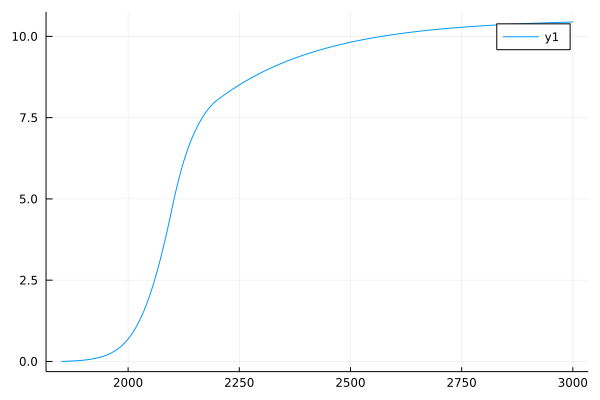

In [31]:
plot(t(m), T(m))

In [32]:
a = [0.2173, 0.2240, 0.2824, 0.2763]
τ = [394.4, 36.54, 4.304]

a_ocean = [60.29, -26.48, -17.45, -16.35]./100.
τ_ocean = [390.5, 100.5, 4.551]

a_land = [17.07, 332.1, -334.1, -15.09]./100.
τ_land = [74.76, 70.31, 6.139]

heavyfunc(f, t) = f .* (t.>=0.)

function IRF(t, a, τ)
    return a[1] .+ sum([aa .* exp.(-t/ττ) for (aa, ττ) in zip(a[2:end], τ)])
end

IRF (generic function with 1 method)

In [33]:
CO2up_ocean(t) = IRF(t, a_ocean, τ_ocean)
CO2up_land(t) = IRF(t, a_land, τ_land)
CO2up(t) = CO2up_land(t) + CO2up_ocean(t)

CO2up (generic function with 1 method)

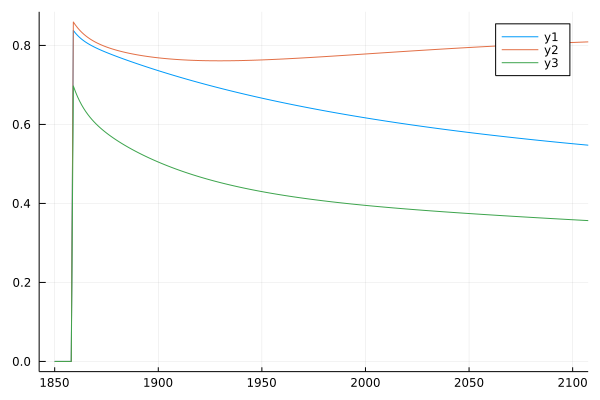

In [34]:
p = plot(t(m), heavyfunc(1 .- CO2up_ocean(t(m) .- t(m)[1]), t(m) .- t(m)[10]))
plot!(p, t(m), heavyfunc(1 .- CO2up_land(t(m) .- t(m)[1]), t(m) .- t(m)[10]))
plot!(p, t(m), heavyfunc(1 .- CO2up(t(m) .- t(m)[1]), t(m) .- t(m)[10]))
plot!(xlim=[1850, 2100])

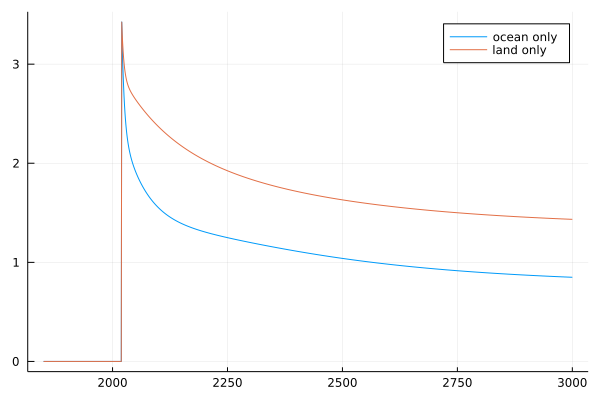

In [35]:
CO2pulse(t, t0) = heavyfunc(1. .- CO2up(t .- t0), t .- t0)
CO2pulse_landonly(t, t0) = heavyfunc(1. .- CO2up_land(t .- t0), t .- t0)
CO2pulse_landonly(t, t0) = heavyfunc(1. .- CO2up_ocean(t .- t0), t .- t0)

n = t(m).==2020

plot(t(m), q[n].*CO2pulse(t(m), t(m)[n]), label="ocean only")
plot!(t(m), q[n].*CO2pulse_landonly(t(m), t(m)[n]), label="land only")

In [36]:
CO2_nouptake(t, dt, q, c0) = c0 .+ sum([q[n]*(t.>=t[n])*dt for n = 1:length(t)])
CO2_oceanonly(t, dt, q, c0) = c0 .+ sum([q[n]*CO2pulse_oceanonly(t, t[n])*dt for n = 1:length(t)])
CO2_landonly(t, dt, q, c0) = c0 .+ sum([q[n]*CO2pulse_landonly(t, t[n])*dt for n = 1:length(t)])
CO2(t, dt, q, c0) = c0 .+ sum([q[n]*CO2pulse(t, t[n])*dt for n = 1:length(t)])

CO2 (generic function with 1 method)

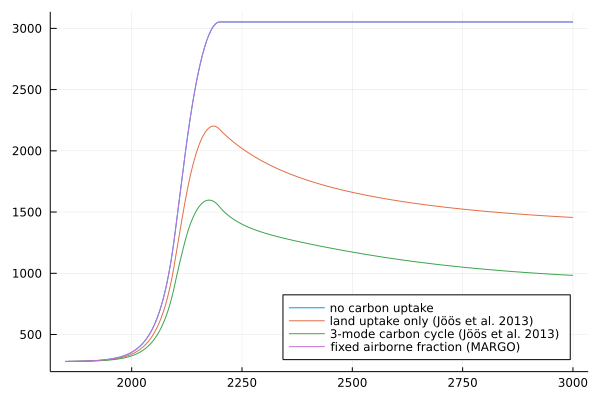

In [37]:
co2_nouptake = CO2_nouptake(t(m), m.domain.dt, q, m.physics.c0)
co2_ocean = CO2_landonly(t(m), m.domain.dt, q, m.physics.c0)
co2_land = CO2_landonly(t(m), m.domain.dt, q, m.physics.c0)
co2 = CO2(t(m), m.domain.dt, q, m.physics.c0)

plot(t(m), co2_nouptake, label="no carbon uptake")
plot!(t(m), co2_land, label="land uptake only (Jöös et al. 2013)")
plot!(t(m), co2, label="3-mode carbon cycle (Jöös et al. 2013)")
plot!(t(m), c(m), label="fixed airborne fraction (MARGO)")
plot!(legend=:bottomright)

In [38]:
phys = m.physics
T0 = phys.T0
c0 = phys.c0
Cd = phys.Cd
κ = phys.κ
B = phys.B
dt = m.domain.dt

a = phys.a
Finf = m.economics.Finf
G = zeros(length(t(m)))

T_fast = T0 .+ F(a, c0, Finf, co2_nouptake, G)/B
T_fast_land = T0 .+ F(a, c0, Finf, co2_land, G)/B
T_fast_all = T0 .+ F(a, c0, Finf, co2, G)/B
T_full = T(T0, F(a, c0, Finf, co2, G), Cd, κ, B, t(m), dt);

In [39]:
T_fast = T0 .+ F(a, c0, Finf, co2_nouptake, G)/B
T_slow = T(T0, F(a, c0, Finf, co2_nouptake, G), Cd, κ, B, t(m), dt);
T_slow_ocean = T(T0, F(a, c0, Finf, co2_ocean, G), Cd, κ, B, t(m), dt);
T_all = T(T0, F(a, c0, Finf, co2, G), Cd, κ, B, t(m), dt);

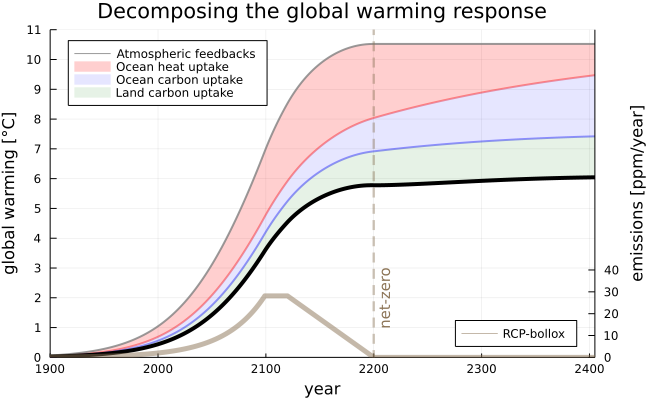

In [40]:
p = plot()

plot!([], [], color=:grey, lw=2., label="Atmospheric feedbacks", size=(650, 400), alpha=0.8)

plot!(t(m), [T_fast], fillrange=[T_slow T_fast], fillalpha=0.19, c=:red, lw=0, label="Ocean heat uptake")
plot!(t(m), [T_slow], color=:red, lw=2., label=nothing, alpha=0.4)

plot!(t(m), [T_fast], color=:grey, lw=2., label=nothing, alpha=0.8)

plot!(t(m), [T_slow], fillrange=[T_slow_ocean T_slow], fillalpha=0.1, c=:blue, lw=0, label="Ocean carbon uptake")
plot!(t(m), [T_slow_ocean], color=:blue, lw=2., label=nothing, alpha=0.4)

plot!(t(m), [T_slow_ocean], fillrange=[T_all T_slow_ocean], fillalpha=0.1, c=:green, lw=0, label="Land carbon uptake")
plot!(t(m), [T_all], color=:black, lw=4., label=nothing)

plot!(legend=:topleft, xlabel="year", ylabel="global warming [°C]", title="Decomposing the global warming response", xlim=(1900, 2405), ylim=(0., 11.), yticks=0:1:11, right_margin = 12Plots.mm)

vline!([2200.], color=:burlywood4, lw=2.5, alpha=0.4, ls=:dash, label=nothing)
annotate!(2210, 2.0, Plots.text("net-zero", 10, :burlywood4, rotation = 90 ))

plot!(twinx(), t(m), q, color=:burlywood4, lw=5., label="RCP-bollox", alpha=0.5, xticks=[], legend=:bottomright, xlim=(1900, 2405), ylim=(0., 150.), ylabel="emissions [ppm/year]", yticks=0:10:40, right_margin = 12Plots.mm)
savefig(p, "global_warming_4.png")

p